In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from data_pre import get_df, data_prep, one_hot, evaluation
from matplotlib.ticker import FuncFormatter

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
 #Import Data from statsbombpy
competitions = sb.competitions()
fifa_2022 = sb.matches(competition_id=43, season_id=106)

#Grouped events
events_fifa = sb.competition_events(
    country="International",
    division='FIFA World Cup',
    season="2022",
    gender="male"
)

In [3]:
risk_df = get_df(events_fifa)

In [4]:
risk_df = data_prep(risk_df)
#risk_df = one_hot(risk_df)

Number of risky passes: 10,952
Number of NOT risky passes: 894.0
Number of NOT risky passes: 108.0


In [5]:
#Examine thhe frerquency of the explanatory vars
#We do that because we have multicolinearity
def dummy_cmpltns():
    for col in risk_df.columns:
        print(col + ': ' + str(risk_df[col].sum()))

dummy_cmpltns()

pass_outcome: 10952
pass_length: 1366242.07186141
pass_angle: 900.8581417027001
pass_height: Ground PassGround PassGround PassHigh PassGround PassHigh PassHigh PassLow PassGround PassGround PassGround PassGround PassGround PassGround PassHigh PassLow PassHigh PassHigh PassHigh PassGround PassGround PassGround PassGround PassGround PassHigh PassGround PassGround PassHigh PassGround PassGround PassGround PassGround PassGround PassLow PassGround PassHigh PassHigh PassHigh PassHigh PassGround PassGround PassGround PassGround PassGround PassGround PassGround PassGround PassGround PassGround PassGround PassHigh PassHigh PassGround PassGround PassHigh PassHigh PassGround PassGround PassGround PassHigh PassGround PassGround PassGround PassGround PassLow PassGround PassGround PassHigh PassGround PassHigh PassGround PassGround PassHigh PassLow PassHigh PassHigh PassGround PassGround PassHigh PassLow PassGround PassGround PassHigh PassGround PassGround PassHigh PassGround PassGround PassGround Pa

In [6]:
risk_df = one_hot(risk_df)

In [7]:
#Drop the cols with very low completeness
risk_df = risk_df.drop(columns=['pass_body_part_Drop Kick', 'pass_body_part_Keeper Arm','pass_body_part_No Touch','pass_body_part_Other' ])

dummy_cmpltns()

pass_outcome: 10952
pass_length: 1366242.07186141
pass_angle: 900.8581417027001
pass_height_Ground Pass: 49618
pass_height_High Pass: 10045
pass_height_Low Pass: 4717
pass_body_part_Head: 2368
pass_body_part_Left Foot: 19618
pass_body_part_Right Foot: 41378


In [8]:
#Reduce the amount of dependent variable's values
# Calculate the number of rows to keep (10% of the total number of rows)
#rows_to_keep = int(len(risk_df) * 0.4)

# Identify the rows where the binary variable is 1
#rows_to_remove = risk_df[risk_df['pass_outcome'] == 0].sample(frac=0.6).index

# Remove the identified rows
#df_2 = risk_df.drop(rows_to_remove)

Logit Model with Removed 0 Rows

In [9]:
# Extract the dependent variable (y) and explanatory variables (X)
#y2 = df_2.iloc[:, 0]
#X2 = df_2.iloc[:, 1:]
# Add a constant term to the explanatory variables for the intercept
#X2 = sm.add_constant(X2)
# Fit a logistic regression model (logit)
#logit_model2 = sm.Logit(y2, X2)
#logit_result2 = logit_model2.fit()
#print("Logit Regression Results:")
#print(logit_result2.summary())

Optimization terminated successfully.
         Current function value: 0.483454
         Iterations 6


Logit Model

In [8]:
# Extract the dependent variable (y) and explanatory variables (X)
y = risk_df.iloc[:, 0]
X = risk_df.iloc[:, 1:]

# Add a constant term to the explanatory variables for the intercept
X = sm.add_constant(X)

In [9]:
# Fit a logistic regression model (logit)
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.350241
         Iterations 7


In [10]:
print("Logit Regression Results:")
print(logit_result.summary())

Logit Regression Results:
                           Logit Regression Results                           
Dep. Variable:           pass_outcome   No. Observations:                64380
Model:                          Logit   Df Residuals:                    64371
Method:                           MLE   Df Model:                            8
Date:                Sat, 17 Feb 2024   Pseudo R-squ.:                  0.2320
Time:                        19:38:37   Log-Likelihood:                -22549.
converged:                       True   LL-Null:                       -29362.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.0319        nan        nan        nan         nan         nan
pass_length                  -0.0036      0.001     -4.020  

In [13]:
#LATEX code
coeffs = logit_result.params
coeffs = coeffs.to_frame(name = 'Coefficients_Logit')
#print(coeffs.to_latex())

Logit Model - Prediction - Classification

In [11]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant term to the explanatory variables for the intercept
X_test = sm.add_constant(X_test)

In [12]:
# Fit a logistic regression model (logit)
logit_model = sm.Logit(y_train, X_train)
logit_result = logit_model.fit()

# Predict on the test set
logit_predictions = logit_result.predict(X_test)
logit_predictions_binary = np.round(logit_predictions)

Optimization terminated successfully.
         Current function value: 0.349932
         Iterations 7


In [13]:
# Evaluate logit model performance
print("\nLogit Model Performance:")
print("Accuracy:", accuracy_score(y_test, logit_predictions_binary))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, logit_predictions_binary))
#print("\nClassification Report:\n", classification_report(y_test, logit_predictions_binary))


Logit Model Performance:
Accuracy: 0.8486331158744952

Confusion Matrix:
 [[9925  727]
 [1222 1002]]


Tuning - Logit

In [37]:
thresholds = []
for i in range(15, 100, 5):
    thresholds.append(i/100)

accuracy_values = []
# Calculate accuracy for each threshold
for threshold in thresholds:
    y_pred = (logit_predictions >= threshold).astype(int)
    accuracy=  accuracy_score(y_test, y_pred)*100
    accuracy_values.append(accuracy)
    #print(f'Threshold: {threshold}, Accuracy: {accuracy:.2f}')

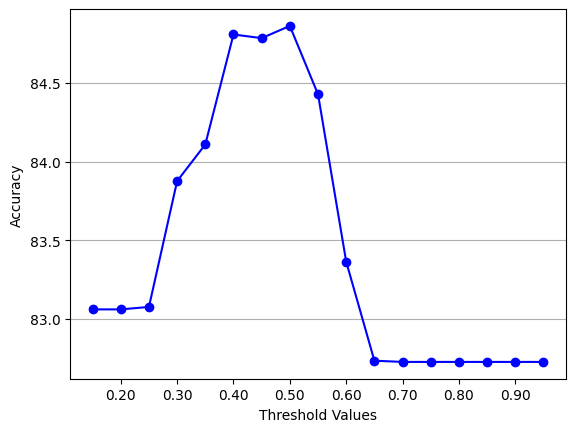

In [38]:
# Plot the line graph
plt.plot(thresholds, accuracy_values, color='blue', marker='o')
#plt.title('Threshold Tuning')
plt.xlabel('Threshold Values')
plt.ylabel('Accuracy')
plt.grid(axis='y')  # Remove vertical grid lines
# Format x-axis ticks to display only 2 decimal places
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.2f}".format(x)))
plt.savefig(f'threshold_tuning.png', bbox_inches='tight')

plt.show()

Evaluation - Logit

In [17]:
df_eval_logit = evaluation(y_test, logit_predictions_binary)

In [18]:
df_eval_logit

,Value
Accuracy,84.86
Misclassification Rate,15.14
Sensitivity,45.05
Specificity,93.17
Precision,57.95


Probit Model

In [19]:
# Fit a probit regression model
probit_model = sm.Probit(y, X)
probit_result = probit_model.fit()

Optimization terminated successfully.
         Current function value: 0.350089
         Iterations 6


In [20]:
print("Probit Regression Results:")
print(probit_result.summary())

Probit Regression Results:
                          Probit Regression Results                           
Dep. Variable:           pass_outcome   No. Observations:                64380
Model:                         Probit   Df Residuals:                    64371
Method:                           MLE   Df Model:                            8
Date:                Thu, 18 Jan 2024   Pseudo R-squ.:                  0.2324
Time:                        15:59:07   Log-Likelihood:                -22539.
converged:                       True   LL-Null:                       -29362.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5758   1.87e+05  -3.08e-06      1.000   -3.67e+05    3.67e+05
pass_length                  -0.0030      0.001     -5.881 

In [21]:
#LATEX code

coeffs_probit = probit_result.params
coeffs_probit = coeffs_probit.to_frame(name = 'Coefficients_Probit')
coeffs['Coefficients_Probit'] = coeffs_probit['Coefficients_Probit'] 
#print(coeffs.to_latex())

Prediction - Probit

In [30]:
# Fit a probit regression model
probit_model = sm.Probit(y_train, X_train)
probit_result = probit_model.fit()

# Predict on the test set
probit_predictions = probit_result.predict(X_test)
probit_predictions_binary = np.round(probit_predictions)

Optimization terminated successfully.
         Current function value: 0.349786
         Iterations 6


In [31]:
accuracy_values = []
# Calculate accuracy for each threshold
for threshold in thresholds:
    y_pred = (probit_predictions >= threshold).astype(int)
    accuracy=  accuracy_score(y_test, y_pred)*100
    accuracy_values.append(accuracy)
    #print(f'Threshold: {threshold}, Accuracy: {accuracy:.2f}')

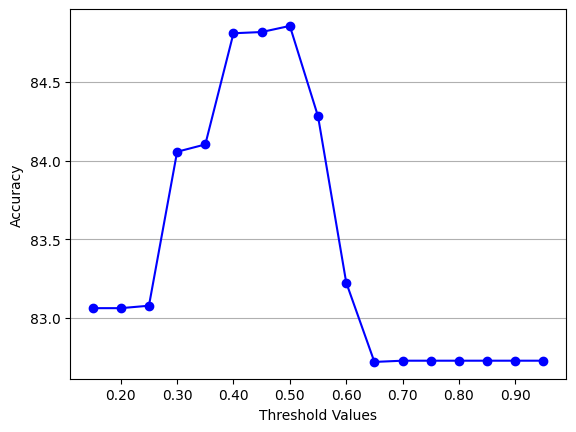

In [32]:
plt.plot(thresholds, accuracy_values, color='blue', marker='o')
#plt.title('Threshold Tuning')
plt.xlabel('Threshold Values')
plt.ylabel('Accuracy')
plt.grid(axis='y')  # Remove vertical grid lines
# Format x-axis ticks to display only 2 decimal places
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: "{:.2f}".format(x)))
plt.savefig(f'threshold_tuning.png', bbox_inches='tight')

In [23]:
# Evaluate probit model performance
print("Probit Model Performance:")
print("Accuracy:", accuracy_score(y_test, probit_predictions_binary))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, probit_predictions_binary))
#print("\nClassification Report:\n", classification_report(y_test, probit_predictions_binary))


Probit Model Performance:
Accuracy: 0.8485554520037278

Confusion Matrix:
 [[9921  731]
 [1219 1005]]


In [24]:
df_eval_probit = evaluation(y_test, probit_predictions_binary)

In [25]:
df_eval_logit['values_probit'] = df_eval_probit['Value']
df_eval_logit

,Value,values_probit
Accuracy,84.86,84.86
Misclassification Rate,15.14,15.14
Sensitivity,45.05,45.19
Specificity,93.17,93.14
Precision,57.95,57.89


In [26]:
print(df_eval_logit.to_latex())

\begin{tabular}{lll}
\toprule
{} &  Value & values\_probit \\
\midrule
Accuracy               &  84.86 &         84.86 \\
Misclassification Rate &  15.14 &         15.14 \\
Sensitivity            &  45.05 &         45.19 \\
Specificity            &  93.17 &         93.14 \\
Precision              &  57.95 &         57.89 \\
\bottomrule
\end{tabular}

